# Test sampling algorithms

In [1]:
import math

import matplotlib.pyplot as plt
import torch
import zuko

import ment_torch as ment

In [2]:
plt.style.use("style.mplstyle")

## Create distribution

In [3]:
class RingDistribution:
    def __init__(self) -> None:
        self.ndim = 2

    def prob(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[..., 0]
        x2 = x[..., 1]
        log_prob = torch.sin(torch.pi * x1) - 2.0 * (x1**2 + x2**2 - 2.0) ** 2
        return torch.exp(log_prob)

    def prob_grid(
        self, shape: tuple[int], limits: list[tuple[float, float]]
    ) -> torch.Tensor:
        edges = [
            torch.linspace(limits[i][0], limits[i][1], shape[i] + 1)
            for i in range(self.ndim)
        ]
        coords = [0.5 * (e[:-1] + e[1:]) for e in edges]
        points = torch.stack(
            [c.ravel() for c in torch.meshgrid(*coords, indexing="ij")], axis=-1
        )
        values = self.prob(points)
        values = values.reshape(shape)
        return values, coords

In [4]:
ndim = 2
xmax = 3.0
dist = RingDistribution()

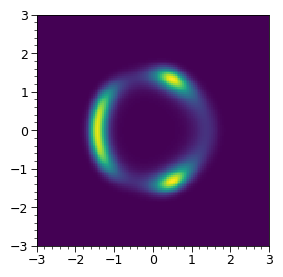

In [5]:
grid_limits = 2 * [(-xmax, xmax)]
grid_shape = (128, 128)
grid_values, grid_coords = dist.prob_grid(grid_shape, grid_limits)

fig, ax = plt.subplots(figsize=(3, 3))
ax.pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
plt.show()

## Sample

In [6]:
def plot_samples(x_pred: torch.Tensor) -> tuple:
    fig, axs = plt.subplots(ncols=2, figsize=(6.0, 2.75), sharex=True, sharey=True)
    axs[0].hist2d(x_pred[:, 0], x_pred[:, 1], bins=80, range=grid_limits)
    axs[1].pcolormesh(grid_coords[0], grid_coords[1], grid_values.T)
    axs[0].set_title("PRED", fontsize="medium")
    axs[1].set_title("TRUE", fontsize="medium")
    return fig, axs

In [7]:
def evaluate_sampler(sampler, size: int = 100_000):
    x_pred = sampler(dist.prob, size=size)
    return plot_samples(x_pred)

### Grid Sampling

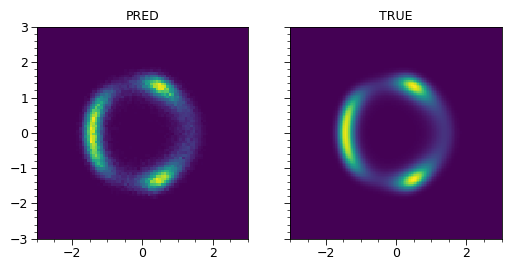

In [8]:
sampler = ment.GridSampler(
    limits=grid_limits,
    shape=grid_shape,
)
evaluate_sampler(sampler);

## Metropolis-Hastings

{'n_total_accepted': tensor(49939), 'n_total': 99990, 'acceptance_rate': tensor(0.4994), 'time': 0.4553236961364746, 'time_per_step': 4.553236961364746e-05}


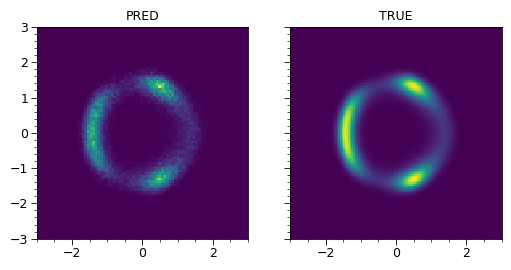

In [9]:
sampler = ment.MetropolisHastingsSampler(
    ndim=ndim,
    proposal_cov=(0.10 * torch.eye(ndim)),
    chains=10,
    verbose=0,
)
evaluate_sampler(sampler);
print(sampler.results)

### Hamiltonian Monte Carlo

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples       | Samples/sec
0d:00:00:51 | 0d:00:00:00 | #################### | 100000/100000 | 1,925.87       
Acceptance Rate 0.89
{}


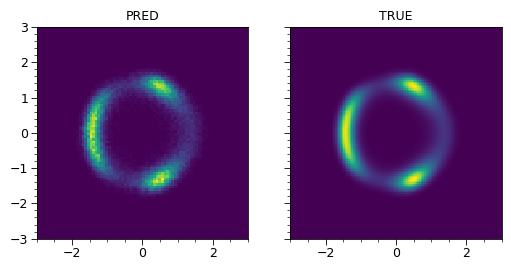

In [10]:
sampler = ment.HamiltonianMonteCarloSampler(
    ndim=ndim,
    chains=1,
    step_size=0.20,
    steps_per_samp=3,
)
evaluate_sampler(sampler)
print(sampler.results)

## Normalizing Flow (NSF)

In [ ]:
flow = zuko.flows.NSF(features=ndim, transforms=3, hidden_features=[64] * 3)
flow = zuko.flows.Flow(flow.transform.inv, flow.base)
sampler = ment.FlowSampler(
    ndim=ndim,
    flow=flow,
    unnorm_matrix=None,
    train_kws=dict(
        iters=1000,
        batch_size=512,
    ),
)
evaluate_sampler(sampler);